In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
from pyod.models.mad import MAD
import statsmodels.api as sm
from sklearn.exceptions import IsolationForest

ImportError: cannot import name 'IsolationForest' from 'sklearn.exceptions' (/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/exceptions.py)

In [21]:
X_train =np.load('X_train.npy')
Y_train =np.load('y_train.npy')
X_test =np.load('X_test.npy')

In [22]:
train_features = ['Air Temperature','Water Temperature','Wind speed','Wind Direction','Illumination']
colours = ['deepskyblue', 'aqua', 'mediumvioletred', 'teal', "gold"]
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train))
X_train_norm = X_train_norm.rename(columns={i:train_features[i] for i in range(5)})
y_train_df = pd.DataFrame(Y_train)
y_train_df.rename(columns={0:'y_train'}, inplace=True)
train_data = X_train_norm.copy()
train_data['Y_train'] = y_train_df.reset_index(drop=True)
train_data

,Air Temperature,Water Temperature,Wind speed,Wind Direction,Illumination,Y_train
0,0.381247,2.062005,0.378296,-0.393807,1.912646,-2.737384
1,-0.649277,-0.818513,2.165169,0.204288,-1.004879,-0.410969
2,-1.030509,-0.806199,-0.143433,-0.002829,-1.177856,14.833533
3,-1.930055,-0.942637,-1.331726,-0.966561,-1.733425,3.960804
4,0.939597,0.603392,-2.257478,-1.753702,0.944511,10.400393
...,...,...,...,...,...,...
195,0.377893,1.377785,0.457462,2.182375,1.451819,-2.356786
196,-0.240140,0.336880,-0.289301,1.212552,0.294484,-0.679252
197,1.040903,0.378041,-0.261347,-0.551529,0.842015,-2.202706
198,0.335330,0.772736,-0.675532,0.118341,0.806821,9.637862


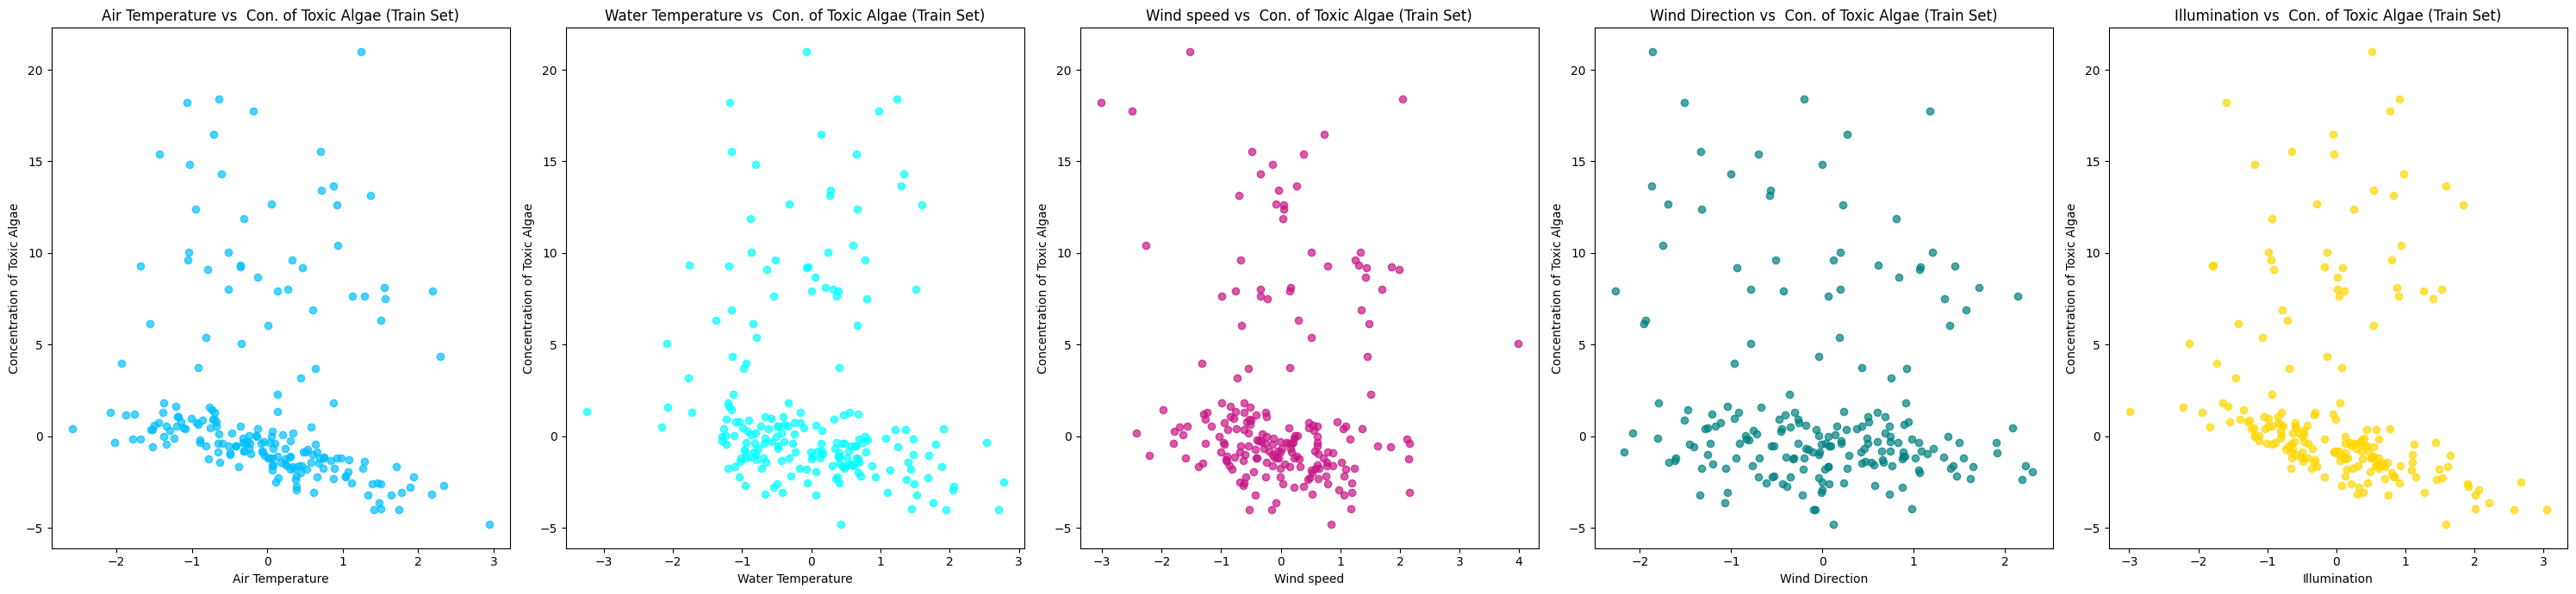

In [23]:
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(X_train_norm[feature], Y_train, alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

"Those variables are often affected by two main types of noise: (i) instrument noise η, which researchers have found to be well approximated by a zero mean white Gaussian noise, and (ii) human error ξ in handling the instruments and the resulting data, which researchers cannot precisely model but usually results in larger errors than instrument noise. Human error has been found to affect about 25% of the samples of the dependent variables, but it is negligible in the measurement of the independent variables." As such, the effects of the human error, that is the major source of error, are only visible in the dependent variable - Concentration of Toxic Algae. Let us focus on that variable to identify and exclude the outliers. To visualize the data, we show an histogram and a box plot. 

IQR Method

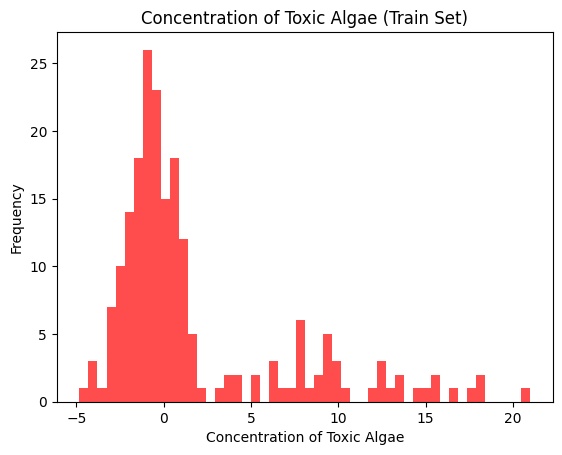

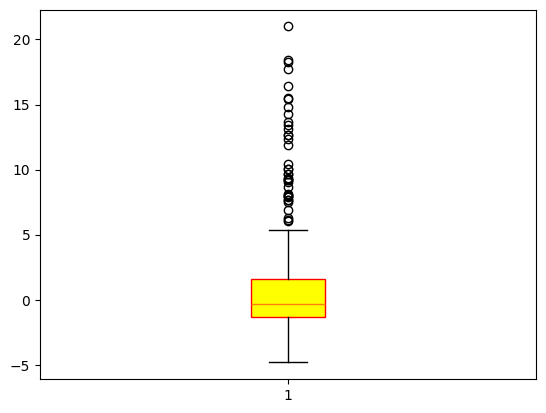

Multiplier: 1.5, Outlier Percentage: 19.50%
Multiplier: 1.4, Outlier Percentage: 19.50%
Multiplier: 1.2999999999999998, Outlier Percentage: 20.00%
Multiplier: 1.1999999999999997, Outlier Percentage: 21.00%
Multiplier: 1.0999999999999996, Outlier Percentage: 21.00%
Multiplier: 0.9999999999999997, Outlier Percentage: 21.00%
Multiplier: 0.8999999999999997, Outlier Percentage: 23.00%
Multiplier: 0.7999999999999997, Outlier Percentage: 24.00%
Multiplier: 0.6999999999999997, Outlier Percentage: 25.00%

Final Multiplier: 0.6999999999999997
Number of outliers: 50
Outlier Percentage: 25.00%


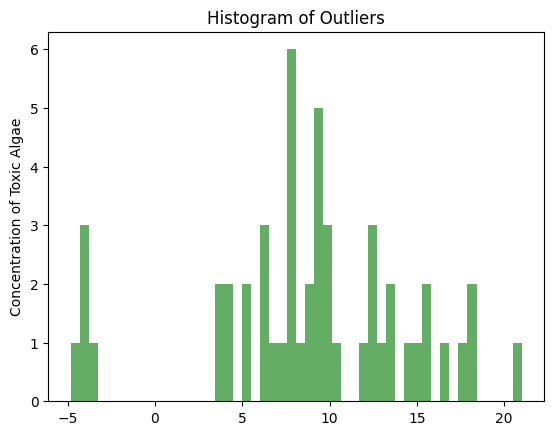

In [24]:
plt.hist(Y_train, bins=50, color='red', alpha=0.7)
plt.title('Concentration of Toxic Algae (Train Set)')
plt.xlabel('Concentration of Toxic Algae')
plt.ylabel('Frequency')
plt.show()

plt.boxplot(Y_train,patch_artist=True,boxprops=dict(facecolor='yellow', color='red'))
plt.show()

def calculate_outliers(multiplier):
    Q1 = train_data['Y_train'].quantile(0.25)
    Q3 = train_data['Y_train'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = train_data['Y_train'][(train_data['Y_train'] < lower_bound) | (train_data['Y_train'] > upper_bound)]
    return outliers

target_percentage = 0.25
multiplier = 1.5
step = 0.1

while True:
    outliers = calculate_outliers(multiplier)
    outlier_percentage = len(outliers) / len(train_data['Y_train'])
    print(f"Multiplier: {multiplier}, Outlier Percentage: {outlier_percentage:.2%}")
    
    if outlier_percentage >= target_percentage:
        break
    multiplier -= step

print(f"\nFinal Multiplier: {multiplier}")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier Percentage: {outlier_percentage:.2%}")

plt.hist(outliers, bins=50, color='forestgreen', alpha=0.7)
plt.title('Histogram of Outliers')
plt.ylabel('Concentration of Toxic Algae')
plt.show()

Just a test: https://stackoverflow.com/questions/38163562/adjusted-boxplot-in-python

At asymmetric distributions the usual boxplot typically flags many regular data points as outliers. The skewness-adjusted boxplot corrects for this by using a robust measure of skewness in determining the fence.

In [25]:
Q1 = train_data['Y_train'].quantile(0.25)
Q3 = train_data['Y_train'].quantile(0.75)
MC = sm.stats.stattools.medcouple(train_data['Y_train']) 
if (MC>0):
    outlier_range_lower = Q1 - 1.5 * np.exp(-4*MC) * (Q3-Q1)
    outlier_range_upper = Q3 + 1.5 * np.exp(3*MC)  * (Q3-Q1)
else:
    outlier_range_lower = Q1 - 1.5 * np.exp(-3*MC) * (Q3-Q1)
    outlier_range_upper = Q3 + 1.5 * np.exp(4*MC)  * (Q3-Q1)

outliers_ajd_boxplot = train_data['Y_train'][(train_data['Y_train'] < outlier_range_lower) | (train_data['Y_train'] > outlier_range_upper)]
print(f"Number of outliers: {len(outliers_ajd_boxplot)}")

Number of outliers: 29


**Method 1: Least Squares Method (LSM)**

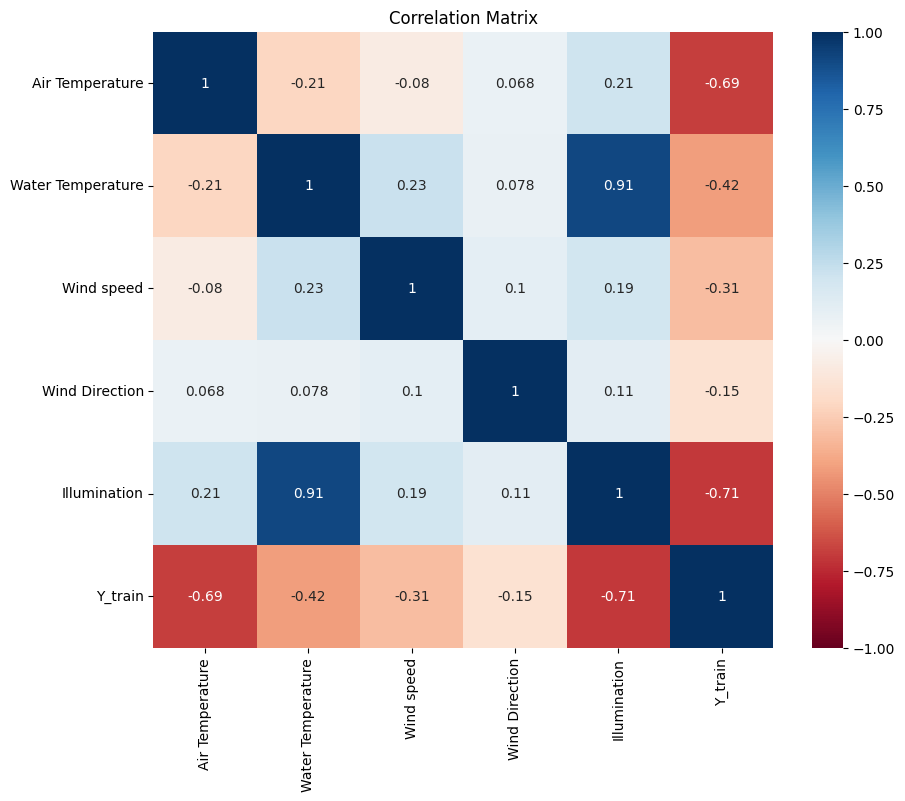

In [44]:
# Removing outliers

def remove_outliers(data, outliers):
    # Remove rows from data where the 'y' column contains values present in the 'outliers' list
    cleaned_data = data[~data['Y_train'].isin(outliers).reset_index(drop=True)]
    
    return cleaned_data

# Get the cleaned data

cleaned_data = remove_outliers(train_data, outliers)
correlation_matrix = cleaned_data.corr()
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [54]:
lr = LinearRegression()

lr.fit(cleaned_data[train_features], cleaned_data['Y_train'])
y_pred = lr.predict(cleaned_data[train_features])
print(f"Coefficients: {lr.coef_}")

alpha = [0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

ratios = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in range(0,12):
    lasso = Lasso(alpha=alpha[i])
    lasso.fit(cleaned_data[train_features], cleaned_data['Y_train'])
    y_pred = lasso.predict(cleaned_data[train_features])
    mse = mean_squared_error(cleaned_data['Y_train'], y_pred)
    r_squared = lasso.score(cleaned_data[train_features], cleaned_data['Y_train'])
    laso_mse = np.append(alpha[i], mse)
    laso_r_squared = np.append(alpha[i], r_squared)
    print(f"Alpha: {alpha[i]}, Coefficients: {lasso.coef_}, MSE: {mse}, R^2: {r_squared}")
    ridge = Ridge(alpha=alpha[i])
    ridge.fit(cleaned_data[train_features], cleaned_data['Y_train'])
    y_pred = ridge.predict(cleaned_data[train_features])
    ridge_r_squared = ridge.score(cleaned_data[train_features], cleaned_data['Y_train'])
    print(f"Alpha: {alpha[i]}, Coefficients: {ridge.coef_}, , MSE: {mse}, R^2: {ridge_r_squared}")

Coefficients: [-1.29198598 -1.08891613 -0.34873687 -0.03840892  0.43354615]
Alpha: 0.0001, Coefficients: [-1.23931726 -0.97148823 -0.34845527 -0.03847201  0.30736948], MSE: 0.19835562247355243, R^2: 0.8757125387247482
Alpha: 0.0001, Coefficients: [-1.29174983 -1.08839032 -0.3487359  -0.03840972  0.4329814 ], , MSE: 0.19835562247355243, R^2: 0.8757359238145228
Alpha: 0.001, Coefficients: [-1.11024805 -0.68496947 -0.34710741 -0.03807855 -0.        ], MSE: 0.19876239404385643, R^2: 0.875457660112478
Alpha: 0.001, Coefficients: [-1.28963674 -1.08368535 -0.34872721 -0.03841682  0.42792799], , MSE: 0.19876239404385643, R^2: 0.8757358778930713
Alpha: 0.01, Coefficients: [-0.79510627 -0.         -0.33675763 -0.03140874 -0.72795641], MSE: 0.20188622944846618, R^2: 0.8735002990503662
Alpha: 0.01, Coefficients: [-1.26965085 -1.0391922  -0.34864354 -0.03848432  0.38014093], , MSE: 0.20188622944846618, R^2: 0.8757317319148891
Alpha: 0.1, Coefficients: [-0.70014476 -0.         -0.23279432 -0.       

/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e+00, tolerance: 2.394e-02
  model = cd_fast.enet_coordinate_descent(


Alpha: 0.2, Coefficients: [-0.59251871 -0.         -0.1139122  -0.         -0.59157124], MSE: 0.32277812309005255, R^2: 0.7977507621221961
Alpha: 0.2, Coefficients: [-1.07265954 -0.60211002 -0.34751528 -0.03921526 -0.08905816], , MSE: 0.32277812309005255, R^2: 0.8753330491174262
Alpha: 0.3, Coefficients: [-0.48549162 -0.         -0.         -0.         -0.51742679], MSE: 0.46988763149139523, R^2: 0.7055735548383891
Alpha: 0.3, Coefficients: [-1.03226121 -0.5133556  -0.34710148 -0.03940449 -0.18418856], , MSE: 0.46988763149139523, R^2: 0.8751715934017282
Alpha: 0.4, Coefficients: [-0.39220495 -0.         -0.         -0.         -0.41886627], MSE: 0.6041805120712807, R^2: 0.6214271062201253
Alpha: 0.4, Coefficients: [-1.0057602  -0.45562835 -0.34672762 -0.03955064 -0.24597998], , MSE: 0.6041805120712807, R^2: 0.8750509871739847
Alpha: 0.5, Coefficients: [-0.29892002 -0.         -0.         -0.         -0.32030538], MSE: 0.7768417288850507, R^2: 0.5132394782070067
Alpha: 0.5, Coefficients

MAD Method

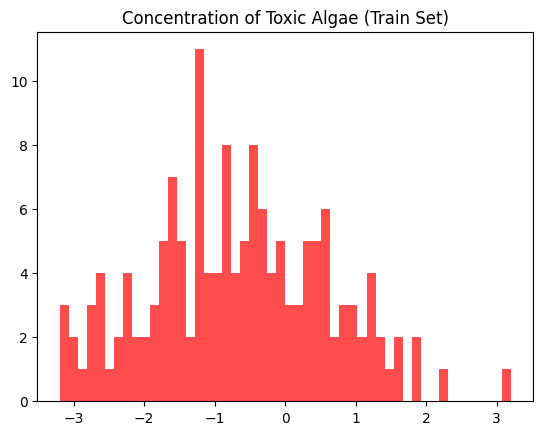

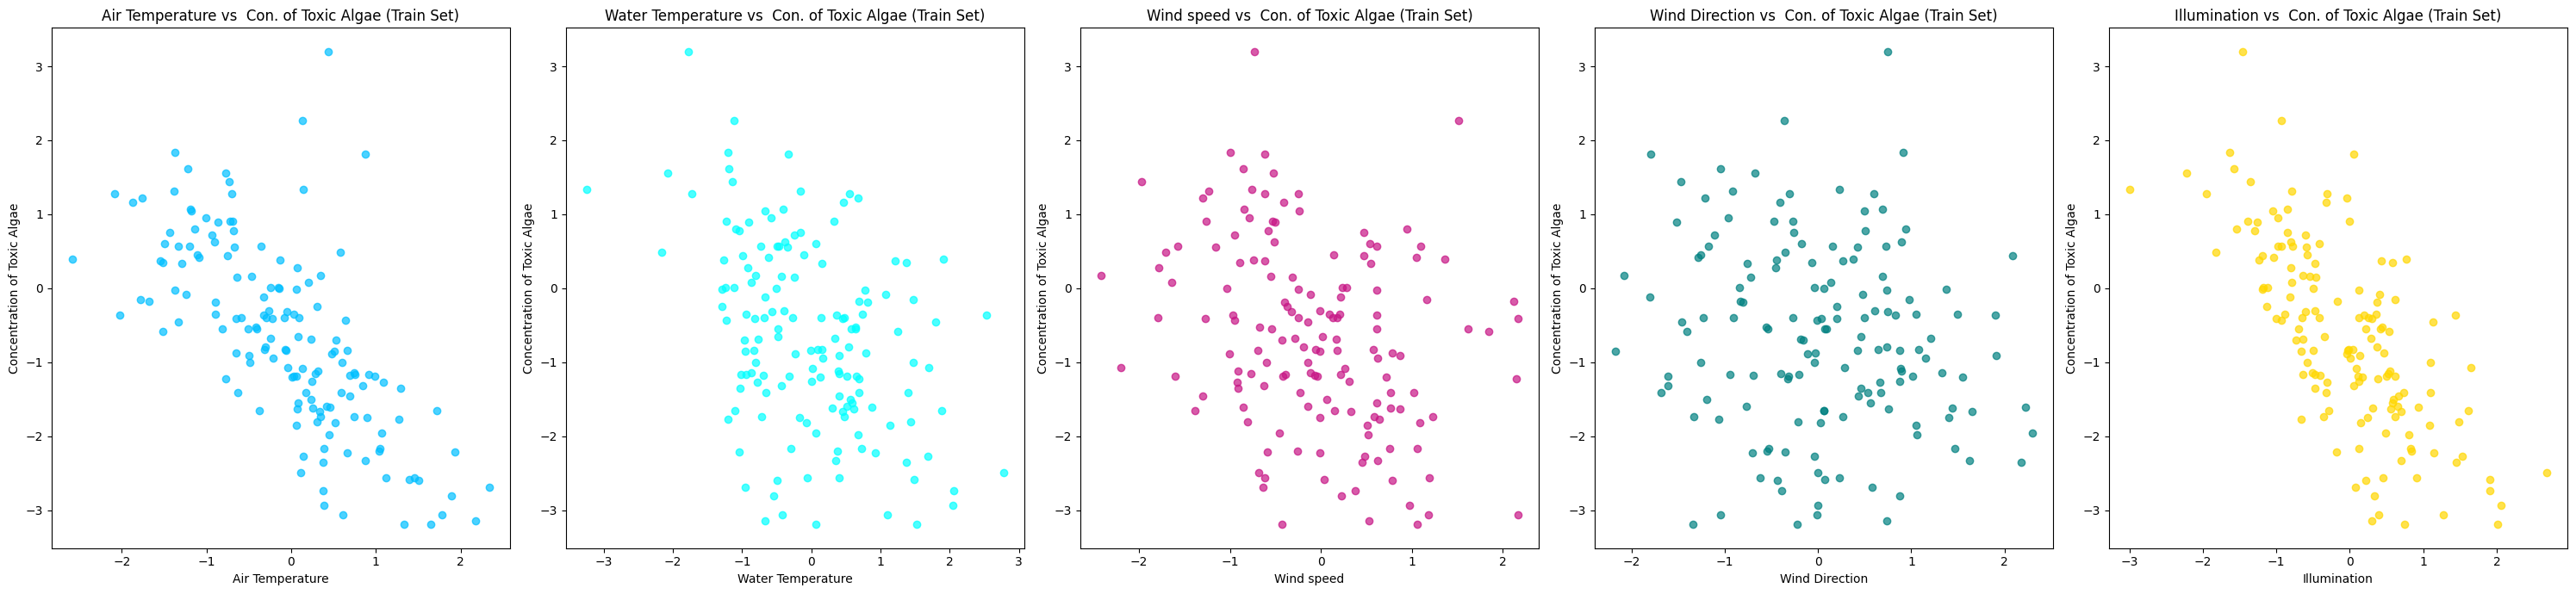

In [53]:
plt.hist(cleaned_data['Y_train'], bins=50, color='red', alpha=0.7)
plt.title('Concentration of Toxic Algae (Train Set)')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(cleaned_data[feature], cleaned_data['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

In [58]:
iso_forest = IsolationForest(contamination=0.25)
outlier_predictions = iso_forest.fit_predict(train_data[train_features])
cleaned_data = train_data[~(outlier_predictions == -1)]

NameError: name 'IsolationForest' is not defined